In [ ]:
 from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
import string
import numpy as np
from PIL import Image
import os
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from pickle import dump, load
import matplotlib.pyplot as plt
import cv2
import io
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, concatenate
from tensorflow.keras.models import load_model, Model

from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
os.listdir('/content/drive/MyDrive/Project Dataset/Flickr8k_text')

['CrowdFlowerAnnotations.txt',
 'ExpertAnnotations.txt',
 'Flickr8k.lemma.token.txt',
 'readme.txt',
 'Flickr_8k.testImages.txt',
 'Flickr8k.token.txt',
 'Flickr_8k.trainImages.txt',
 'Flickr_8k.devImages.txt']

In [ ]:
dataset_images_path = '/content/drive/MyDrive/Project Dataset/Flicker8k_Dataset'
dataset_text_path = '/content/drive/MyDrive/Project Dataset/Flickr8k_text'

In [ ]:
def load_txt(path):
    file = open(path, 'r')
    content = file.read()
    file.close()
    return content
# load_txt(dataset_text_path)

In [ ]:
def make_dic(path):
    content = load_txt(path)
    lines = content.split('\n')
    dic = {}
    for line in lines[:-1]:
#         print(line)
        img_name, caption = line.split('\t')
        img_name = img_name[:-2]
        if img_name not in dic.keys():
            dic[img_name] = [caption]
        else:
            dic[img_name].append(caption)
    return dic

In [ ]:
def clean_caption(dic):
    filter_table = str.maketrans('', '', string.punctuation)
    for img_name, caption_list in dic.items():
        for i, caption in enumerate(caption_list):
            caption = caption.replace('-', ' ') # from "truck-driver" to "truck driver"
            word_list = caption.split()
            word_list = map(lambda x: x.lower().translate(filter_table), word_list)
            word_list = [word for word in word_list if len(word) > 1 and word.isalpha()] # remove numeric words and "a" character
            caption = ' '.join(word_list)
            dic[img_name][i] = caption
    return dic

In [ ]:
def extract_vocabulary(dic):
    vocab = set()
    for k in dic.keys():
        [vocab.update(d.split()) for d in dic[k]]
    return vocab

In [ ]:
def save_dic_to_text(dic, path):
    lines = list()
    for img_name, caption_list in dic.items():
        for caption in caption_list:
            lines.append(img_name + '\t' + caption)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()

In [ ]:
descriptions = make_dic(dataset_text_path + '/' + 'Flickr8k.token.txt')
cleaned_descriptions = clean_caption(descriptions)
vocabulary = extract_vocabulary(cleaned_descriptions)
save_dic_to_text(cleaned_descriptions, 'cleaned_descriptions.txt')

In [ ]:
def extract_feature(path):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img_name in tqdm(os.listdir(path)):
        img_path = path + '/' + img_name
        img = Image.open(img_path)
        img = img.resize((300, 300))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 127.5 - 1.0
        feature = model.predict(img, verbose=0)
        features[img_name] = feature
    return features

In [ ]:
features = extract_feature(dataset_images_path)
print("Extracted features: ",len(features))
dump(features, open('features.p', 'wb'))
features = load(open('features.p', 'rb'))

83683744/83683744 [==============================] - 4s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

Extracted features:  8091


In [ ]:
def load_img_name_list(path):
    content = load_txt(path)
    img_name_list = content.split('\n')[:-1]
    return img_name_list

In [ ]:
def load_cleaned_descriptions(path, img_name_list):
    content = load_txt(path)
    dic = {}
    for line in content.split('\n'):
        word_list = line.split()
        if len(word_list) < 1:
            continue
        img_name, caption_word_list = word_list[0], word_list[1:]
        if img_name in img_name_list:
            if img_name not in dic:
                dic[img_name] = []
            caption = '<start> ' + ' '.join(caption_word_list) + ' <end>'
            dic[img_name].append(caption)
    return dic

In [ ]:
def load_features(img_name_list):
    all_features = load(open('features.p', 'rb'))
    features = { k: all_features[k] for k in img_name_list }
    return features

In [ ]:
train_img_list = load_img_name_list(dataset_text_path + '/' + 'Flickr_8k.trainImages.txt')
train_descriptions = load_cleaned_descriptions('cleaned_descriptions.txt', train_img_list)
train_features = load_features(train_img_list)

def extract_caption(dic):
    all_captions = list()
    for k in dic.keys():
        [all_captions.append(caption) for caption in dic[k]]
    return all_captions

In [ ]:
def create_tokenizer(dic):
    all_captions = extract_caption(dic)
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(all_captions)
    return tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_max_length_of_caption(dic):
    all_captions = extract_caption(dic)
    return max(len(d.split()) for d in all_captions)

In [ ]:
max_length = get_max_length_of_caption(train_descriptions)
def data_generator(dic, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        n = 0
        X1, X2, y = list(), list(), list()
        for img_name, caption_list in dic.items():
            feature = features[img_name][0]
            for caption in caption_list:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sequence)):
                    in_seq, out_seq = sequence[:i], sequence[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    n += 1
                    if n == batch_size:
                        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                        yield [X1, X2], y
                        n = 0
                        X1, X2, y = list(), list(), list()

In [ ]:
def define_model(total_words, max_length):
    input_1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(input_1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    input_2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(input_2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, activation='relu')(se2)
    
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    
    model = Model(inputs=[input_1, input_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    
    return model

In [ ]:
import random
def caption_viewer(gref, capt):
  with open("/content/cleaned_descriptions.txt",'r') as file:
    # description_f = file.read()
    img_name = gref.split("/")
    img_list = img_name[-1].split(".")
    # print(img_list)
    desc_list = list()
    captions_list = list()
    for line in file:
      if img_list[0] in line:
        desc_list.append(line)
    for every in desc_list:
      var = every.split(" ")
      var = var[1:]
      sentence = " ".join(var)
      captions_list.append(sentence)
    print("start\n"+random.choice(captions_list)+"end")

In [ ]:
model_LSTM = define_model(vocab_size, max_length)
epochs = 18
batch_size = 60
steps = len(train_img_list) // batch_size

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      1873664     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [ ]:
for i in tqdm(range(epochs)):
#     print('Big Epoch ' + str(i+1))
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model_LSTM.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/18 [00:00<?, ?it/s]

100/100 [==============================] - 12s 120ms/step - loss: 1.4882


In [ ]:
model_LSTM.save('models/model_LSTM.h5')

In [ ]:
def test_extract_features(path, model):
    try:
        img = Image.open(path)
    except:
        print('Incorrect path or extension!')
    
    img = img.resize((300, 300))
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[..., :3]
    img = np.expand_dims(img, axis=0)
    img = img / 127.5 - 1.0
#     img = preprocess_input(img)
    feature = model.predict(img, verbose=0)
    return feature

In [ ]:
def test_word_of_id(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None

In [ ]:
def test_generate_caption(model, tokenizer, feature, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = model.predict([feature, sequence], verbose=0)
        prediction = np.argmax(prediction)
        word = test_word_of_id(prediction, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [ ]:
def test_load_doc(path):
    file = open(path, 'r')
    text = file.read()
    file.close()
    return text
def test_load_img_name_list(path):
    text = test_load_doc(path)
    img_name_list = text.split('\n')
    return img_name_list
test_max_length = 35
tokenizer = load(open('tokenizer.p', 'rb'))
model_LSTM = load_model('models/model_LSTM.h5')
xception = Xception(include_top=False, pooling='avg')

In [ ]:
test_img_name_list = test_load_img_name_list(dataset_text_path + '/' + 'Flickr_8k.testImages.txt')

/content/drive/MyDrive/Project Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg
start
girl climbing into wooden playhouse
end


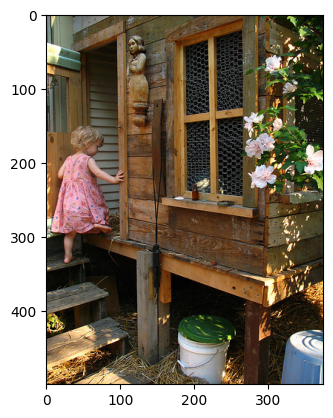

In [ ]:
import random
import sys
from google.colab.patches import cv2_imshow
random_test_image_path = dataset_images_path + '/' + random.choice(test_img_name_list)
random_test_image_path = "/content/drive/MyDrive/Project Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"
test_feature = test_extract_features(random_test_image_path, xception)
image = Image.open(random_test_image_path)
caption = test_generate_caption(model_LSTM, tokenizer, test_feature, max_length)
print(random_test_image_path)
caption_viewer(random_test_image_path, caption)
plt.imshow(image)